 ## CRYPTOCURRENCY PRICE FUNDAMENTALS PREDICTION VIA LSTM NETWORK
 ## MODEL TWO, PRICE NO LONGER AN INPUT
## BY JAMES BURNS
**FOR PROFESSOR KUROCHKIN AND TAS:   
CSCI S-89 2021**

An analysis based primarily on the work:

"The fundamental drivers of cryptocurrency prices"
Siddharth Bhambhwani, Stefanos Delikouras, George Korniotis 24 August 2019
https://voxeu.org/article/fundamental-drivers-cryptocurrency-prices

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import datetime
import statsmodels.api as smt
import time
#stats models OLS tutorial https://www.geeksforgeeks.org/ordinary-least-squares-ols-using-statsmodels/
#Data analysis packages learned from DGMD S-14 Prof.Jose Ramirez Herran, Harvard Summer School

#Patch for dataframe to handle large numbers https://stackoverflow.com/questions/61732956/pandas-read-json-with-int64-values-raises-valueerror-value-is-too-big
pd.io.json._json.loads = lambda s, *a, **kw: json.loads(s)

In [2]:
#Set up default API values
Price = "https://api.glassnode.com/v1/metrics/market/price_usd_close"
Hashrate = "https://api.glassnode.com/v1/metrics/mining/hash_rate_mean"
Accounts = "https://api.glassnode.com/v1/metrics/addresses/active_count"
#Three tokens available
Token = "ETH" #BTC or ETH or LTC
#Year start UNIX timestamps, represent January 1st
Year_2021 = "1609459200"
Year_2020 = "1577854800"
Year_2019 = "1546300800"
Year_2018 = "1514764800"
Year_2017 = "1483228800"
Year_2016 = "1451606400"
#Choose your default start year
Data_start_year = Year_2018
#Choose your default frequency eg "1w" or "24h"
Data_frequency = "24h"
#Choose to log price data by base e
Natural_log = False

In [3]:
def Pull_blockchain_data(token, data_start_year, data_end, data_frequency, data_type, natural_log = False):
    '''
    Portions of code from glassnode API documentation 
    https://docs.glassnode.com/basic-api/api-key#example-using-python
    requests,json,pandas already imported
    natural_log takes the log_e of data, boolean. Default is FALSE.
    '''
    API_KEY = '1rScABdwvd1vnOtqt4FWaI9pdeU'
    '''
    Make API request
    a is your ticker (BTC or ETH or LTC)
    s is timestamp start
    i is frequency, code default is daily, 1w is weekly
    '''
    res = requests.get(data_type,
        params={'a': token, 'api_key': API_KEY, 's':data_start_year, 'u':data_end,'i': data_frequency})
    # convert to pandas dataframe
    df = pd.read_json(res.text, convert_dates=['t'])
    
    logarithmic = ""
    #Loge data transformation
    if natural_log:
        df['v'] = np.log(df['v'])
        logarithmic = "Log_e "
    
    #creates title with currency and data start year
    global Title
    Title = logarithmic + token + " since " + datetime.datetime.utcfromtimestamp(int(data_start_year)).strftime('%Y')
        
    #timestamp change https://stackoverflow.com/questions/3682748/converting-unix-timestamp-string-to-readable-date
    return df


In [4]:
def normalize(df):
    '''
    Built for data from glassnode
    
    Takes natural log of raw data
    Subtracts mean of logged data from result
    Subtracts standard deviation of mean subtracted data
    Returns normalized data column
    Method from Bhambhwani et al.
    '''
    df['v'] = np.log(df['v'])
    df['v'] = ((df['v']) - df['v'].mean())
    df['v'] = ((df['v']) / df['v'].std())
    
    return df


In [5]:
def build_dataframe(token, data_start_year, data_frequency, data_end = int(time.time())):
    '''
    Collects the price, hashrate, and accounts
    Combines into one frame
    '''
    dfp = normalize(Pull_blockchain_data(token, data_start_year, data_end, data_frequency, Price))
    dfh = normalize(Pull_blockchain_data(token, data_start_year, data_end, data_frequency, Hashrate))
    dfa = normalize(Pull_blockchain_data(token, data_start_year, data_end, data_frequency, Accounts))
    
    #change frame name for graphing
    dfp['p'] = dfp['v']
    dfh['h'] = dfh['v']
    dfa['a'] = dfa['v']
    
    frames = [dfp['t'],dfp['p'],dfh['h'],dfa['a']]
    df = pd.concat(frames, axis = 1)
    if data_frequency == "24h":
        df.drop(df.tail(1).index,inplace=True) # drop last row (tomorrow's data)
    
    # deleting last row NaN https://stackoverflow.com/questions/26921651/how-to-delete-the-last-row-of-data-of-a-pandas-dataframe
    # pandas documentaion https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
    return df

In [6]:
def plot_price_hashrate(df):
    x = df['t']
    y1 = df['p']
    y2 = df['h']
    
    
    plt.figure(num = 1, facecolor = 'powderblue', figsize=(12,5))
    plt.plot(x,y2)
    plt.plot(x,y1,
        color='red',
        linestyle='--'
        ) #price is always red line
    plt.title(Title, size = 24)
    plt.ylabel("Normalized Price & Hashrate")
    plt.xlabel("Time")
    
    plt.show()
    
    #labels for plot https://www.w3schools.com/python/matplotlib_labels.asp
    #https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figure.html

In [7]:
def plot_price_accounts(df):
    x = df['t']
    y1 = df['p']
    y2 = df['a']

    plt.figure(num = 2, facecolor = 'tan', figsize=(12,5))
    plt.plot(x,y2)
    plt.plot(x,y1,
        color='red',
        linestyle='--'
        ) #price is always red line
    plt.title(Title, size = 24)
    plt.ylabel("Normalized Price & Active Accounts")
    plt.xlabel("Time")
    
    plt.show()
    
    #labels for plot https://www.w3schools.com/python/matplotlib_labels.asp
    #https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figure.html

In [8]:
#Builds dataframe from API and processes data
#Args are token, start year, frequency, (and optional end year)

df = build_dataframe("BTC", Year_2016, "1w")

In [9]:
#data sample
df.tail()

,t,p,h,a
288,2021-07-05,1.449838,0.856098,0.435600
289,2021-07-12,1.394885,0.877949,0.211456
290,2021-07-19,1.471342,0.874140,0.289420
291,2021-07-26,1.568465,0.929258,0.599190
292,2021-08-02,1.633496,0.940754,0.098989


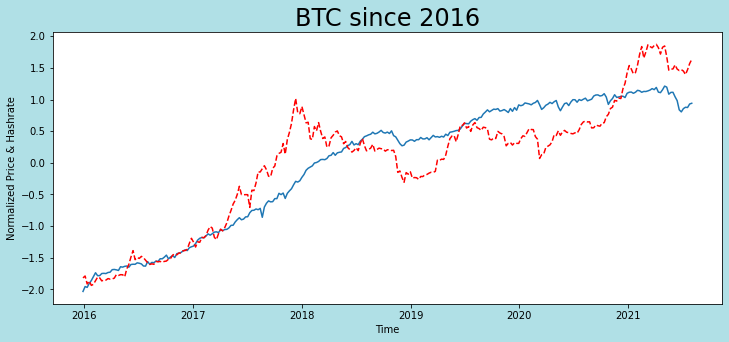

In [10]:
plot_price_hashrate(df)

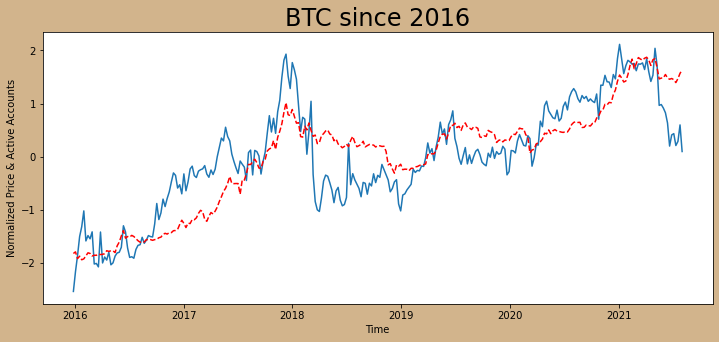

In [11]:
plot_price_accounts(df)

In [12]:
#Use if regression fails due to nan value (data source value for incomplete day/week)
df.drop(df.tail(1).index,inplace=True)

In [13]:
'''
Statsmodels OLS Analysis https://www.geeksforgeeks.org/ordinary-least-squares-ols-using-statsmodels/
Statsmodels multiple regression https://www.datarobot.com/blog/multiple-regression-using-statsmodels/
Statsmodels documentaion for linear OLS https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html

Ordinary Least Squares method used to follow Bhambhwani et al.
High R-squared suggests strong correlation between fundamental factors and price
'''

#normalized dataframe already made
#define variables, hashrate and active_accounts as independent, price as dependent
x = df[['h', 'a']]
y = df['p']

#add constant term
x = smt.add_constant(x)

# performing the regression, fitting the model
result = smt.OLS(y, x).fit()
  
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      p   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     1264.
Date:                Sun, 08 Aug 2021   Prob (F-statistic):          1.26e-143
Time:                        22:12:05   Log-Likelihood:                -80.529
No. Observations:                 292   AIC:                             167.1
Df Residuals:                     289   BIC:                             178.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0034      0.019     -0.184      0.8

# Part II: LSTM Network

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.stattools import acf, pacf

from pandas import DataFrame
from pandas import concat

import keras
from keras import optimizers
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint

#df data imported, normalized above
#df is [time, price, hashrate, activeAccounts] as df = [t,p,h,a]

xt = df
xt = xt.reset_index(drop=True)

In [15]:
xt = xt.to_numpy()

In [16]:
xt

array([[Timestamp('2015-12-28 00:00:00'), -1.8187895780242633,
        -2.032556359805058, -2.532540773010017],
       [Timestamp('2016-01-04 00:00:00'), -1.7882991682460743,
        -1.9552739508771884, -2.1628316651914177],
       [Timestamp('2016-01-11 00:00:00'), -1.9145513836504724,
        -1.9681640125611433, -1.8534469783779857],
       ...,
       [Timestamp('2021-07-12 00:00:00'), 1.394884921969783,
        0.8779492185808788, 0.21145569467021819],
       [Timestamp('2021-07-19 00:00:00'), 1.4713421325351748,
        0.8741395335539442, 0.2894197581655493],
       [Timestamp('2021-07-26 00:00:00'), 1.56846453916184,
        0.9292578349818224, 0.59919033913381]], dtype=object)

In [17]:
xt.shape

(292, 4)

In [18]:
#Convert data into 3d array of 
# shape (observations over time, n_timesteps, n_vars)

n_timesteps = 8

features_set_price = []
labels_price = []
for i in range(n_timesteps, xt.shape[0]):
    features_set_price.append(xt[i-n_timesteps:i,1]) #prices
    labels_price.append(xt[i,1])

features_set_hash = []
labels_hash = []
for i in range(n_timesteps, xt.shape[0]):
    features_set_hash.append(xt[i-n_timesteps:i,2]) 
    labels_hash.append(xt[i,2])
    
features_set_accounts = []
labels_accounts = []
for i in range(n_timesteps, xt.shape[0]):
    features_set_accounts.append(xt[i-n_timesteps:i,3])
    labels_accounts.append(xt[i,3])  

In [19]:
# Combine features_set variables into a single tensor
features_set_price, features_set_hash, features_set_accounts = np.array(features_set_price, dtype=np.float), np.array(features_set_hash, dtype=np.float), np.array(features_set_accounts, dtype=np.float)

labels_price,labels_hash,labels_accounts = np.array(labels_price, dtype=np.float), np.array(labels_hash, dtype=np.float), np.array(labels_accounts, dtype=np.float)

features_set = np.zeros((len(xt) - n_timesteps, n_timesteps, 2))
features_set[:, :, 0] = features_set_hash
features_set[:, :, 1] = features_set_accounts
features_set.shape

(284, 8, 2)

In [20]:
# Combine labels for each variable into a single tensor
labels = np.zeros((len(xt) - n_timesteps, 2))
labels[:, 0] = labels_hash
labels[:, 1] = labels_accounts
labels.shape

(284, 2)

In [21]:
# Creates a variable that represents price only for graphing later
xtPriceOnly = []

for i in range(0, xt.shape[0]):
    xtPriceOnly.append(xt[i,1]) #prices, removed i - num timestamps

xtPriceOnly = pd.Series(xtPriceOnly)
type(xtPriceOnly)

pandas.core.series.Series

In [22]:
# split into train and test sets
n = features_set.shape[0]
n_train = int(n * 0.80)
n_test = n - n_train
#print("n_train = ",str(n_train))
#print("n_test = ",str(n_test))

features_set_train, features_set_test =  features_set[0:n_train,:,:], features_set[n_train:n,:,:]
labels_train, labels_test =  labels[0:n_train], labels[n_train:n]

print("features_set_train.shape is ", features_set_train.shape)
print("labels_train.shape is ", labels_train.shape)
print("\nfeatures_set_test.shape is ", features_set_test.shape)
print("labels_test.shape is ", labels_test.shape)

features_set_train.shape is  (227, 8, 2)
labels_train.shape is  (227, 2)

features_set_test.shape is  (57, 8, 2)
labels_test.shape is  (57, 2)


In [23]:
#Show data structure
print("features:")
display(features_set_train[0:2,:,0])
print("labels:")
display(labels_train[0:2])

features:


array([[-2.03255636, -1.95527395, -1.96816401, -1.90506272, -1.85942229,
        -1.79815159, -1.73710459, -1.78355248],
       [-1.95527395, -1.96816401, -1.90506272, -1.85942229, -1.79815159,
        -1.73710459, -1.78355248, -1.78269153]])

labels:


array([[-1.78269153, -1.54262685],
       [-1.74912934, -1.41184291]])

In [24]:
#Build LSTM Model

n_features = 2
#timestamps variable above

import tensorflow
import tensorflow.keras.layers

model_lstm = models.Sequential()
model_lstm.add(layers.LSTM(20, input_shape=(n_timesteps,n_features))) #more variables here?
model_lstm.add(Dropout(0.2))
model_lstm.add(layers.Dense(1, activation = 'linear'))

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                1840      
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 1,861
Trainable params: 1,861
Non-trainable params: 0
_________________________________________________________________


In [25]:
#Train
nepochs = 25

opt = tf.keras.optimizers.Adam(learning_rate=0.0001) 
#divide lr if not working

model_lstm.compile(loss='mse',optimizer= opt)

history = model_lstm.fit(features_set_train, labels_train,
          epochs=nepochs,
          batch_size=1,
          validation_data=(features_set_test, labels_test))
history = history.history

Epoch 1/25
227/227 [==============================] - 2s 4ms/step - loss: 0.7147 - val_loss: 0.8405
Epoch 2/25
227/227 [==============================] - 1s 2ms/step - loss: 0.4853 - val_loss: 0.5850
Epoch 3/25
227/227 [==============================] - 1s 2ms/step - loss: 0.3492 - val_loss: 0.4241
Epoch 4/25
227/227 [==============================] - 1s 2ms/step - loss: 0.2827 - val_loss: 0.3186
Epoch 5/25
227/227 [==============================] - 1s 2ms/step - loss: 0.2345 - val_loss: 0.2737
Epoch 6/25
227/227 [==============================] - 1s 3ms/step - loss: 0.2215 - val_loss: 0.2437
Epoch 7/25
227/227 [==============================] - 1s 2ms/step - loss: 0.2163 - val_loss: 0.2287
Epoch 8/25
227/227 [==============================] - 1s 2ms/step - loss: 0.2158 - val_loss: 0.2116
Epoch 9/25
227/227 [==============================] - 1s 2ms/step - loss: 0.2251 - val_loss: 0.2094
Epoch 10/25
227/227 [==============================] - 1s 2ms/step - loss: 0.2172 - val_loss: 0.1948

<Figure size 432x288 with 0 Axes>

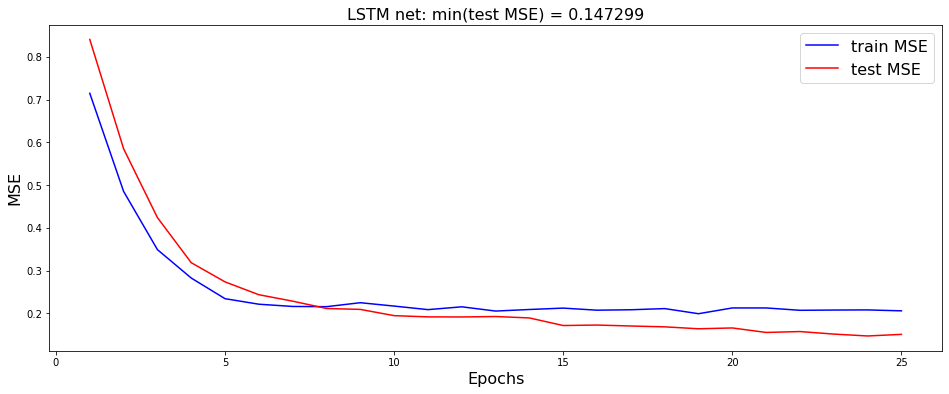

In [26]:
plt.clf()   # clear figure
train_mse = history['loss']
test_mse = history['val_loss']

plt.figure(figsize=(16,6))
plt.plot(range(1,nepochs+1), train_mse, 'b', label='train MSE',color="blue")
plt.plot(range(1,nepochs+1), test_mse, 'b', label='test MSE',color="red")

#plt.ylim((0, 0.0001))
plt.title('LSTM net: min(test MSE) = ' + str(round(min(test_mse),6)),fontsize=16)
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('MSE',fontsize=16)
plt.legend(loc = 'upper right',fontsize=16)
#plt.ylim(0,0.001)

plt.show()

In [27]:
xhat = model_lstm.predict(features_set)
xhat

array([[-1.54386318e+00],
       [-1.52164435e+00],
       [-1.49322104e+00],
       [-1.55811274e+00],
       [-1.60566103e+00],
       [-1.65293169e+00],
       [-1.61393702e+00],
       [-1.65465057e+00],
       [-1.66381204e+00],
       [-1.67783213e+00],
       [-1.67191076e+00],
       [-1.68683231e+00],
       [-1.69061434e+00],
       [-1.67995477e+00],
       [-1.67366719e+00],
       [-1.66065335e+00],
       [-1.63876057e+00],
       [-1.56844747e+00],
       [-1.53238881e+00],
       [-1.53796446e+00],
       [-1.56134260e+00],
       [-1.57859457e+00],
       [-1.59897530e+00],
       [-1.59627223e+00],
       [-1.58761680e+00],
       [-1.58517110e+00],
       [-1.56146276e+00],
       [-1.55388105e+00],
       [-1.53443968e+00],
       [-1.50804901e+00],
       [-1.48876107e+00],
       [-1.47584736e+00],
       [-1.43202615e+00],
       [-1.34011054e+00],
       [-1.31903923e+00],
       [-1.27683771e+00],
       [-1.20385420e+00],
       [-1.17262971e+00],
       [-1.1

In [28]:
len(xtPriceOnly)
type(xtPriceOnly)

pandas.core.series.Series

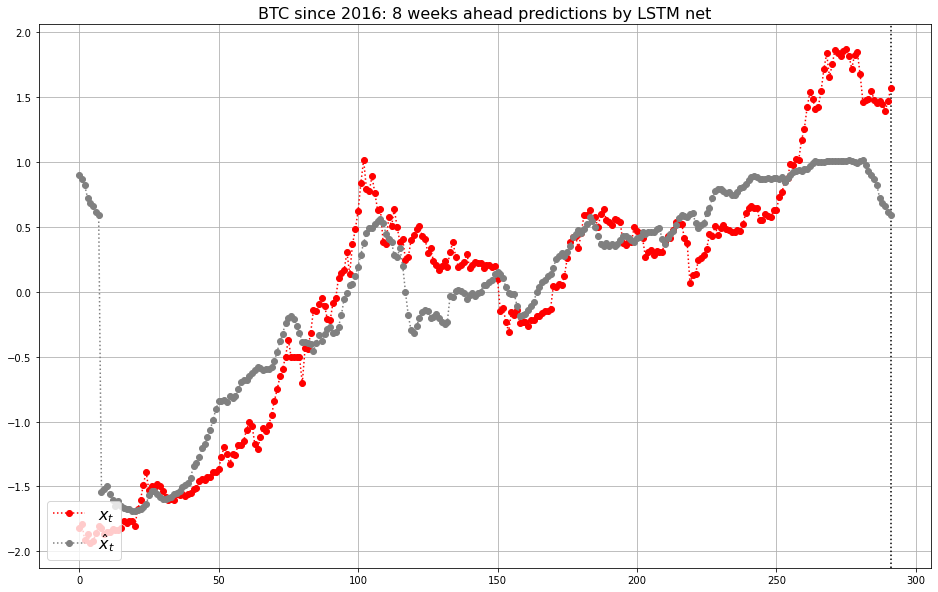

In [29]:
#Graph resulting fundamental price prediction
#Default window size shows all periods
#Default custom window size is 52 (one year under weekly)

window_is_smaller_than_full_dataset = False
window_size_in_periods = 52

if window_is_smaller_than_full_dataset:
    window = np.arange(len(xt) - window_size_in_periods,len(xt))
else:    
    window = np.arange(0,len(xt))

plt.figure(figsize=(16,10))
plt.title(Title + ": " + str(n_timesteps) + " weeks ahead predictions by LSTM net",fontsize=16)

plt.axvline(x= (xt.shape[0])-1,linestyle=':',color='k')
plt.plot(xtPriceOnly.index[window],xtPriceOnly[window], linestyle=':', marker='o',color='red',label = "$x_t$")
plt.plot(xtPriceOnly.index[window],xhat[window-n_timesteps], linestyle=':', marker='o',color='gray',label = "$\hat{x}_t$")

plt.grid(True)
plt.legend(loc = 'lower left',fontsize=16)
plt.show()

#real price is always red